# **AIML CA2 Assignment - Part B (Time-Series Forecasting)**
**Name**: JEROME LOKE  
**Student ID**: P2510707  
**Class**: DAAA/FT/1B/01  

---

### **Tasks, and how I fulfilled them**
##### → _"Evaluate model performance and tune its hyperparameters to maximize the accuracy for training data and testing data predictions. "_

##### → _"Use validation and test data properly."_
  
### NOTE
* Avoid double differencing
  * Do either manual differencing or set d > 0 in ARIMA, not both.
* Tune hyperparameters using validation data only
  * Training → Validation → Test (test set used once at the end).
* Include interpretation for residual diagnostics
  * Briefly state whether residuals resemble white noise.
* Use consistent evaluation metrics
  * Stick to the same 2–3 metrics (e.g. RMSE, MAE) across all models and splits.
* Clearly explain the 60-month forecast procedure
  * State that the final model is refit on the full dataset before forecasting.

### **Machine Learning Workflow**
1. EDA
2. Preprocessing & Feature Engineering
3. Modelling & Evaluation
4. Model Improvement

---

### Import Libraries

In [226]:
# Data Analysis
import pandas as pd
import numpy as np

# Data Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Timeseries
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.tools import diff
from scipy.stats import boxcox 

# Modelling
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

---

## **STAGE 1: EDA (Exploratory Data Analysis)**
* **Preview Dataset**: Display first 5 rows to understand its structure.
* **Handle Time Index**: Convert date column to DatetimeIndex, set correct monthly frequency, check for missing months

### Load & Preview Dataset

In [227]:
df = pd.read_csv("./CA2-datasets/CA2-Energy-Consumption-Data.csv")
print("Missing Values\n", df.isna().sum())

print("\ndf.info():")
df.info()

Missing Values
 DATE                             0
Gas Consumption (tons)           0
Electricity Consumption (MWh)    0
Water Consumption (tons)         0
dtype: int64

df.info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DATE                           397 non-null    object 
 1   Gas Consumption (tons)         397 non-null    float64
 2   Electricity Consumption (MWh)  397 non-null    float64
 3   Water Consumption (tons)       397 non-null    float64
dtypes: float64(3), object(1)
memory usage: 12.5+ KB


In [228]:
# handle time index
df["DATE"] = pd.to_datetime(df["DATE"], format="%d/%m/%Y", errors="coerce") # convert date column to DatetimeIndex
df.set_index("DATE", inplace=True)
df = df.asfreq("MS")

df.head()

,Gas Consumption (tons),Electricity Consumption (MWh),Water Consumption (tons)
DATE,,,
1990-01-01,18.0,725.1,548.8
1990-02-01,15.8,706.7,640.7
1990-03-01,17.3,624.5,511.1
1990-04-01,18.9,574.7,515.3
1990-05-01,22.0,553.2,488.4


### Rename Columns

In [229]:
df.rename(columns={
  "Gas Consumption (tons)": "gas_tons",
  "Electricity Consumption (MWh)": "electricity_mwh",
  "Water Consumption (tons)": "water_tons"
}, inplace=True)
df.head(1)

,gas_tons,electricity_mwh,water_tons
DATE,,,
1990-01-01,18.0,725.1,548.8


### Check Missing Dates & Data

### Time Domain Analysis

Plotting
* Gas consumption over time

* Electricity consumption over time

* Water consumption over time


To get a better idea of overall trend, seasonality, and sudden spikes or drops.

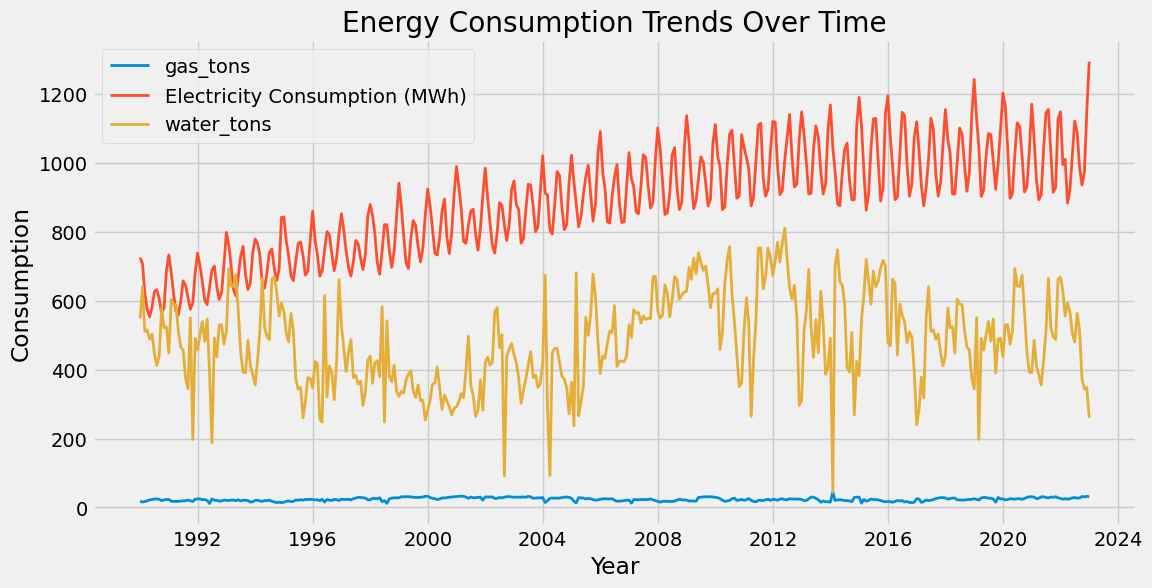

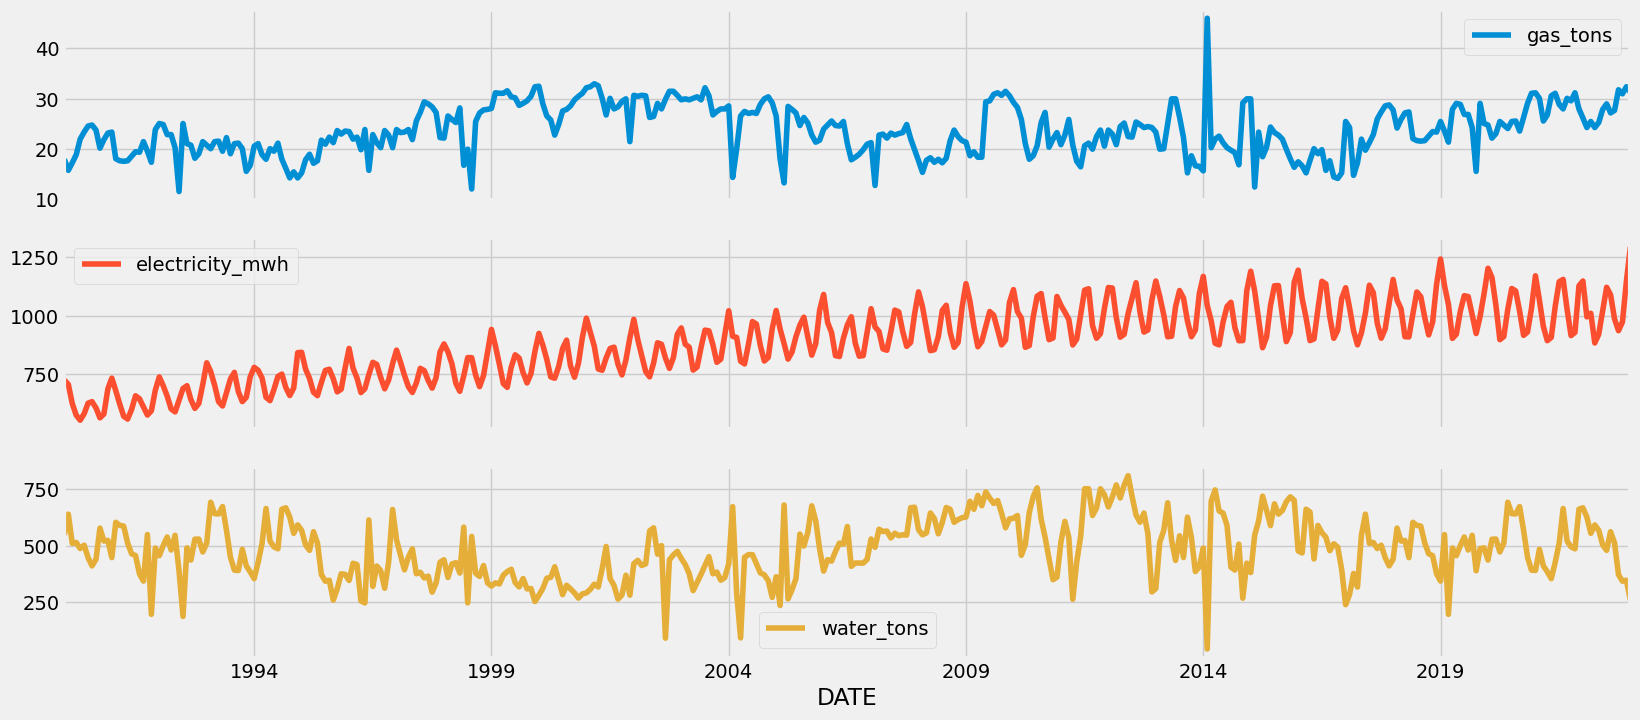

In [230]:
plt.figure(figsize=(12, 6))

# plot each energy type
plt.plot(df.index, df['gas_tons'], label='gas_tons', linewidth=2)
plt.plot(df.index, df['electricity_mwh'], label='Electricity Consumption (MWh)', linewidth=2)
plt.plot(df.index, df['water_tons'], label='water_tons', linewidth=2)

# style
plt.xlabel("Year")
plt.ylabel("Consumption")
plt.title("Energy Consumption Trends Over Time")
plt.grid(True)
plt.legend()
plt.show()

# plotting each on its own
df.plot(subplots=True, figsize=(18, 8))
plt.show()

### Stationarity Analysis
ARIMA expects stationary data (constant mean, variance and autocorrelation over time). This stability makes the data predictable, as its behavior is not dependent on the observation time.

In [231]:
rolling_window = 12 # months
consumption_types = [
  'electricity_mwh',
  'water_tons',
  'gas_tons'
]

cons_pal = {
  'electricity_mwh': "#FFA500",
  'water_tons': "#1E90FF",
  'gas_tons': "#1B7E1B"
}

##### Standardise Consumption Levels

In [232]:
scaler = StandardScaler()
df_scaled = df.copy()

df_scaled[consumption_types] = scaler.fit_transform(
  df[consumption_types]
)

##### Scaled SMA
- To directly compare series with different scales (e.g. electricity VS gas).
- Identify which series is more volatile **relative to itself**.

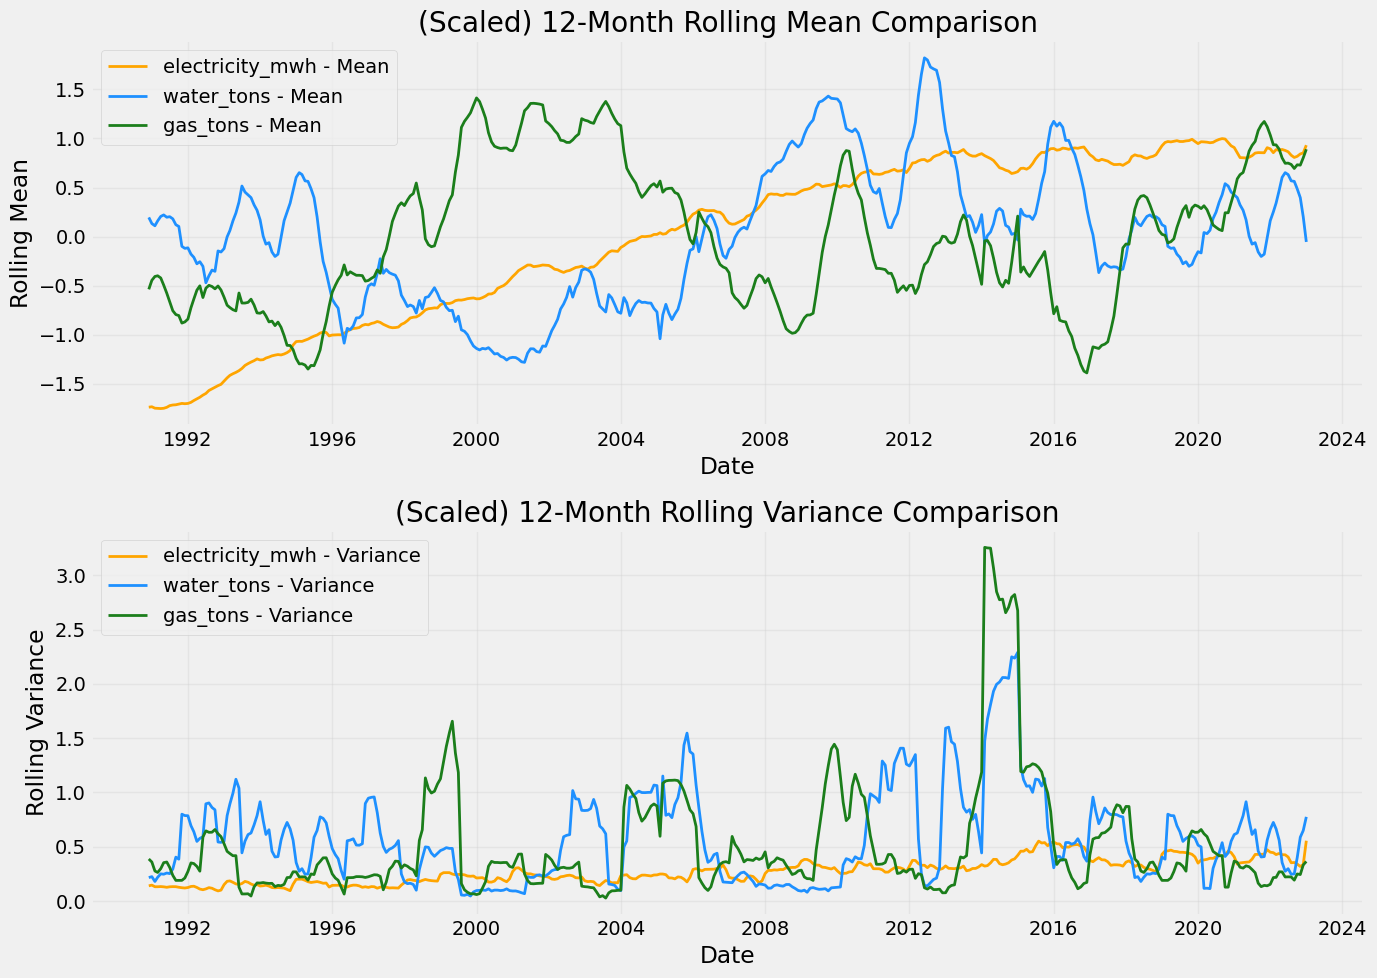

In [233]:
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

for col in consumption_types:
  rolling_mean = df_scaled[col].rolling(rolling_window).mean()
  rolling_var = df_scaled[col].rolling(rolling_window).var()
  ax[0].plot(
    df_scaled.index, rolling_mean, label=f'{col} - Mean', 
    linewidth=2, color=cons_pal[col]
  )
  ax[1].plot(
    df_scaled.index, rolling_var, label=f'{col} - Variance', 
    linewidth=2, color=cons_pal[col]
  )

ax[0].set_title("(Scaled) 12-Month Rolling Mean Comparison")
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Rolling Mean')
ax[0].legend(loc='upper left')
ax[0].grid(True, alpha=0.3)

ax[1].set_xlabel('Date')
ax[1].legend(loc='upper left')
ax[1].grid(True, alpha=0.3)
ax[1].set_ylabel('Rolling Variance')
ax[1].set_title("(Scaled) 12-Month Rolling Variance Comparison")

plt.tight_layout()
plt.show()

##### Unscaled SMA
- Checking trend
- Checking seasonality
- Checking variance growth

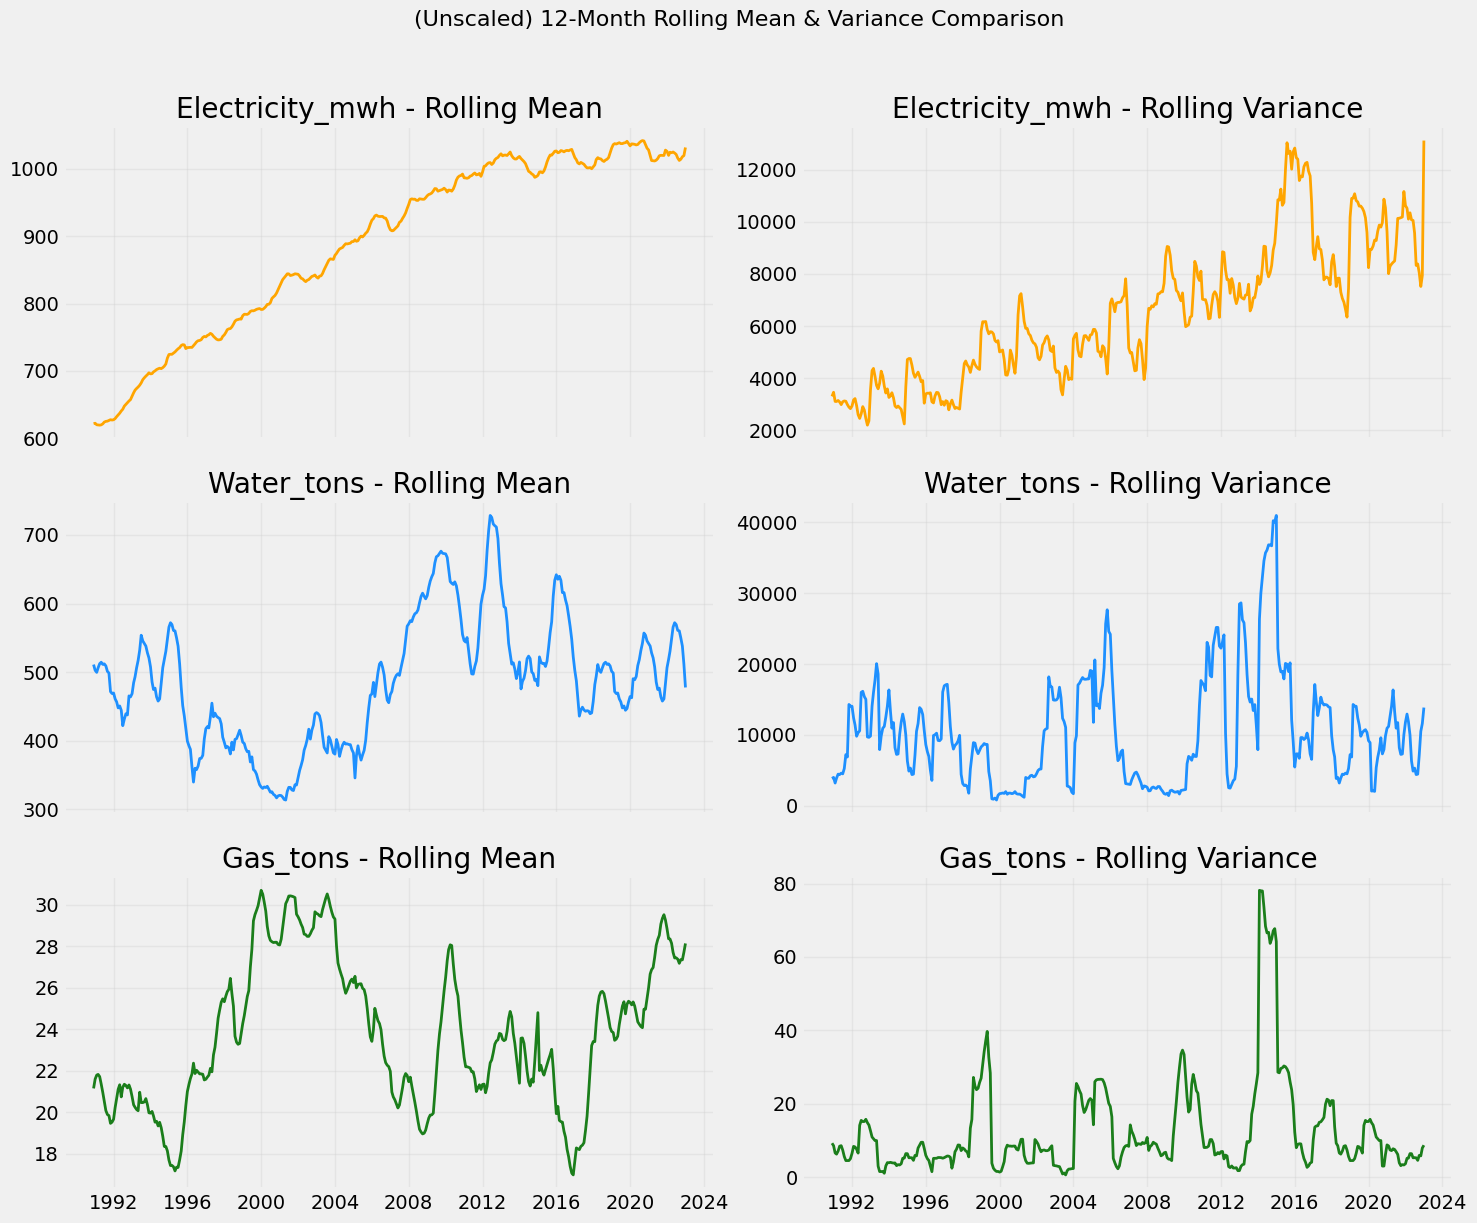

In [234]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12), sharex=True)
fig.suptitle("(Unscaled) 12-Month Rolling Mean & Variance Comparison", fontsize=16, y=1.02)

for i, col in enumerate(consumption_types):
  rolling_mean = df[col].rolling(rolling_window).mean()
  rolling_var = df[col].rolling(rolling_window).var()

  # plot rolling mean
  axes[i, 0].plot(df.index, rolling_mean, linewidth=2, color=cons_pal[col])
  axes[i, 0].set_title(f"{col.capitalize()} - Rolling Mean")

  # plot rolling variance
  axes[i, 1].plot(df.index, rolling_var, linewidth=2, color=cons_pal[col])
  axes[i, 1].set_title(f"{col.capitalize()} - Rolling Variance")

for ax in axes.flatten():
  ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Scaled (measured **relative deviations**/changes)
- Rolling mean for Water and Gas show huge fluctuations indicating erratic shifts from normal behaviour, while that for Electricity shows a smooth upward trend.

- Similar case for Rolling variance, Water and Gas will require variance-stabilising transformations while Electricity will not.

Unscaled
- Rolling Mean shows an increasing trend as expected.

- No clear seasons identified

- Rolling Variance shows an increasing trend, with fluctuations growing over time.

Next Steps: Further stationarity tests to validate our visual findings, and considering the Box-Cox transformation for Water and Gas consumption to stabilise their variances.

#### ADF (Augmented Dickey-Fuller) Test


In [235]:
def adf_test(series, name=""):
  result = adfuller(series.dropna())

  print(f"ADF Test for {name}")
  print(f"Test Statistic: {result[0]:.4f}")
  print(f"p-value: {result[1]:.4f}")
  print("Critical Values:")

  for key, value in result[4].items():
    print(f"   {key}: {value:.4f}")

  if result[1] < 0.05:
    print("Conclusion: Reject H0 → Series is stationary")
  else:
    print("Conclusion: Fail to reject H0 → Series is non-stationary")

  print("\n")

adf_test(df['electricity_mwh'], "Electricity Consumption")
adf_test(df['water_tons'], "Water Consumption")
adf_test(df['gas_tons'], "Gas Consumption")

ADF Test for Electricity Consumption
Test Statistic: -2.2570
p-value: 0.1862
Critical Values:
   1%: -3.4476
   5%: -2.8692
   10%: -2.5708
Conclusion: Fail to reject H0 → Series is non-stationary


ADF Test for Water Consumption
Test Statistic: -4.6848
p-value: 0.0001
Critical Values:
   1%: -3.4471
   5%: -2.8689
   10%: -2.5707
Conclusion: Reject H0 → Series is stationary


ADF Test for Gas Consumption
Test Statistic: -3.4044
p-value: 0.0108
Critical Values:
   1%: -3.4472
   5%: -2.8690
   10%: -2.5707
Conclusion: Reject H0 → Series is stationary




#### KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Test

In [236]:
def kpss_test(series, name="", regression="c"):
  statistic, p_value, lags, critical_values = kpss(
    series.dropna(),
    regression=regression,
    nlags="auto"
  )

  print(f"KPSS Test for {name}")
  print(f"Test Statistic: {statistic:.4f}")
  print(f"p-value: {p_value:.4f}")
  print("Critical Values:")

  for key, value in critical_values.items():
    print(f"   {key}: {value}")

  if p_value < 0.05:
    print("Conclusion: Reject H0 → Series is non-stationary")
  else:
    print("Conclusion: Fail to reject H0 → Series is stationary")
  print("\n")

kpss_test(df['electricity_mwh'], "Electricity Consumption")
kpss_test(df['water_tons'], "Water Consumption")
kpss_test(df['gas_tons'], "Gas Consumption")

KPSS Test for Electricity Consumption
Test Statistic: 3.5316
p-value: 0.0100
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
Conclusion: Reject H0 → Series is non-stationary


KPSS Test for Water Consumption
Test Statistic: 0.8388
p-value: 0.0100
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
Conclusion: Reject H0 → Series is non-stationary


KPSS Test for Gas Consumption
Test Statistic: 0.3402
p-value: 0.1000
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
Conclusion: Fail to reject H0 → Series is stationary




C:\Users\lokej\AppData\Local\Temp\ipykernel_24360\1236932188.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, lags, critical_values = kpss(
C:\Users\lokej\AppData\Local\Temp\ipykernel_24360\1236932188.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, lags, critical_values = kpss(
C:\Users\lokej\AppData\Local\Temp\ipykernel_24360\1236932188.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, lags, critical_values = kpss(


#### Interpret ADF & KPSS Results
![Interpret ADF and KPSS table](<attachment:Screenshot 2026-01-29 205752.png>)

**Summary of Results**
| Energy Type | ADF p-value | ADF Conclusion | KPSS p-value | KPSS Conclusion | Overall Stationarity |
|-----------|------------|---------------|-------------|----------------|---------------------|
| Electricity | 0.1862 | Non-stationary | 0.0100 | Non-stationary | **Non-stationary** |
| Water | 0.0001 | Stationary | 0.0100 | Non-stationary | **Inconclusive (trend-stationary)** |
| Gas | 0.0108 | Stationary | 0.1000 | Stationary | **Stationary** |

Electricity
- Both ADF and KPSS tests indicate changing mean over time. Differencing required.

Water
- ADF suggests stationarity, while KPSS rejects it, indicating trend-stationarity. Differencing or detrending required.

Gas
- Both ADF and KPSS tests suggest stationarity. Differencing not required.

_Note: The KPSS interpolation warnings indicate very strong evidence for the conclusions and do not invalidate the results._
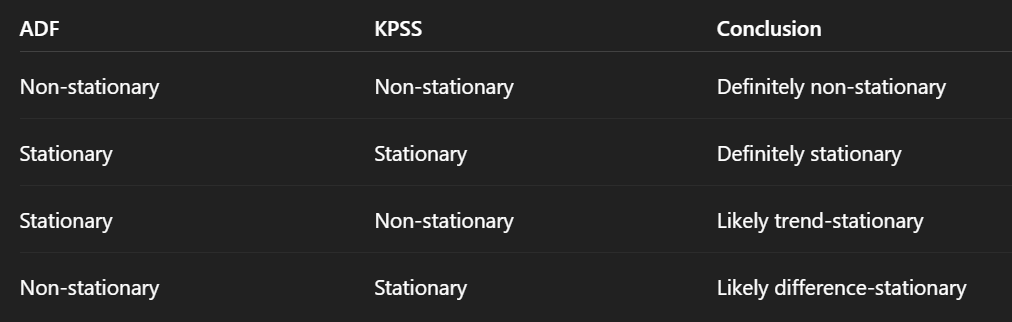

---

## **STAGE 2: Preprocessing & Feature Engineering**

### Box-Cox transform
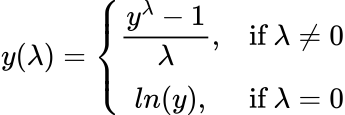

Lambda value is estimated by maximising the likelihood of the transformed original series. It tells us what power should be applied to the raw data distribution.

Box–Cox reshapes the data distribution to make it:
- more symmetric
- less right-skewed
- more constant in variance over time

#### Calculate λ
Decide if Box-Cox is necessary for each feature.

In [237]:
ys_bc = {}
lambdas_bc = {}

for type in consumption_types:
  y = df[type]
  y_bc, lambda_bc = boxcox(y)
  ys_bc[type] = y_bc
  lambdas_bc[type] = lambda_bc

lambdas_bc

{'electricity_mwh': np.float64(1.074887946525938),
 'water_tons': np.float64(1.0426534628565798),
 'gas_tons': np.float64(0.7801343902718498)}

- Water and Electricity consumption do not require boxcox as their lambda values (~1.04 & ~1.07 respectively) are very near 1. Applying the transformation would effect minimal changes to the data.

- Gas consumption shows mild right skew, Box–Cox can gently compress the data.

- **NOTE:** After performing first-order differencing on Electricity consumption, I noticed that the differenced series' rolling variance still shows a mild upward trend (not constant). Thus, I backtracked and applied box-cox to it too.

#### Box-Cox `gas_tons`

In [238]:
df["gas_tons_bc"] = ys_bc["gas_tons"]
df["electricity_mwh_bc"] = ys_bc["electricity_mwh"]
print("Preview new DataFrame:\n", df.head())

Preview new DataFrame:
             gas_tons  electricity_mwh  water_tons  gas_tons_bc  \
DATE                                                             
1990-01-01      18.0            725.1       548.8    10.939313   
1990-02-01      15.8            706.7       640.7     9.757537   
1990-03-01      17.3            624.5       511.1    10.566930   
1990-04-01      18.9            574.7       515.3    11.413451   
1990-05-01      22.0            553.2       488.4    13.010422   

            electricity_mwh_bc  
DATE                            
1990-01-01         1103.768866  
1990-02-01         1073.665779  
1990-03-01          939.920850  
1990-04-01          859.522147  
1990-05-01          824.970290  


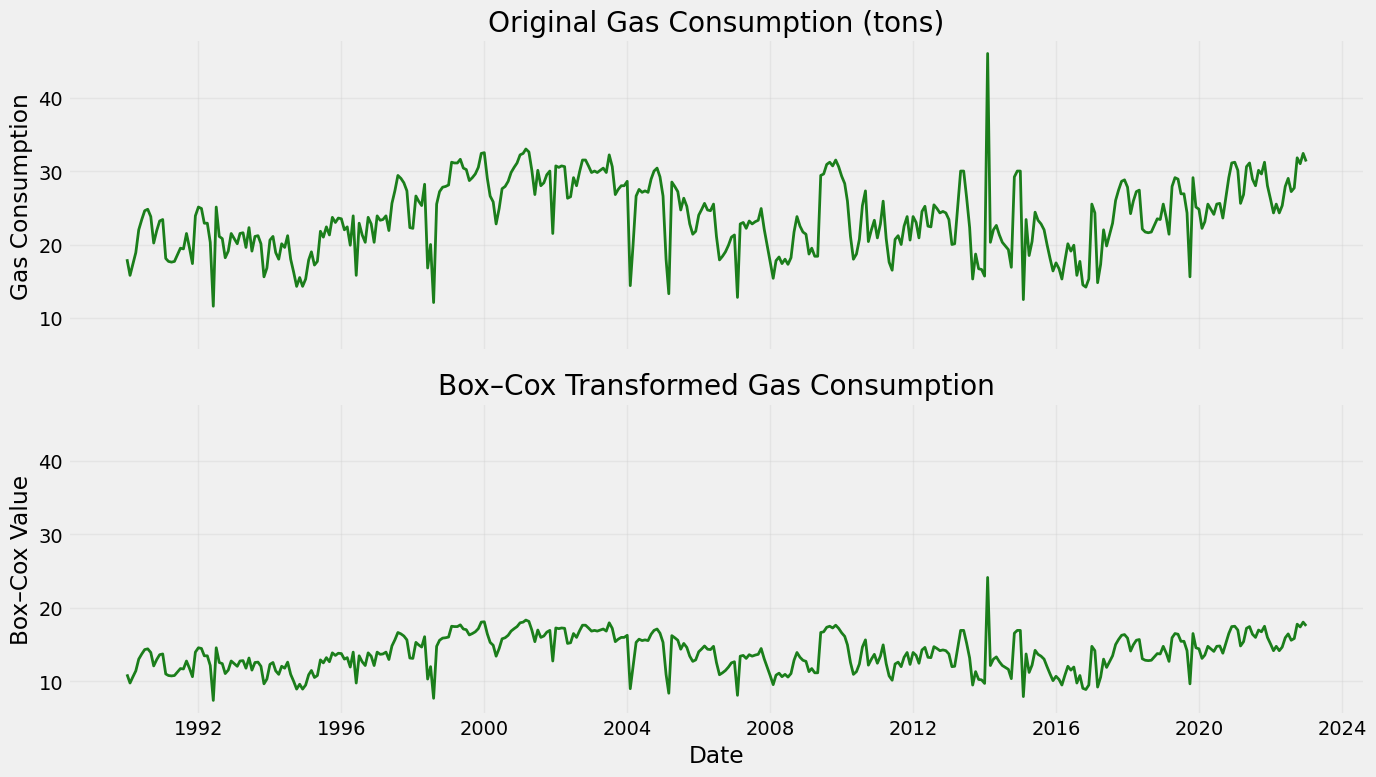

In [239]:
# plot comparison for Gas
fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True, sharey=True)

# Original Gas consumption
ax[0].plot(df.index, df["gas_tons"], linewidth=2, color=cons_pal["gas_tons"])
ax[0].set_title("Original Gas Consumption (tons)")
ax[0].set_ylabel("Gas Consumption")
ax[0].grid(True, alpha=0.3)

# Box–Cox transformed Gas consumption
ax[1].plot(df.index, df["gas_tons_bc"], linewidth=2, color=cons_pal["gas_tons"])
ax[1].set_title("Box–Cox Transformed Gas Consumption")
ax[1].set_ylabel("Box–Cox Value")
ax[1].set_xlabel("Date")
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Box_Cox `electricity_mwh`

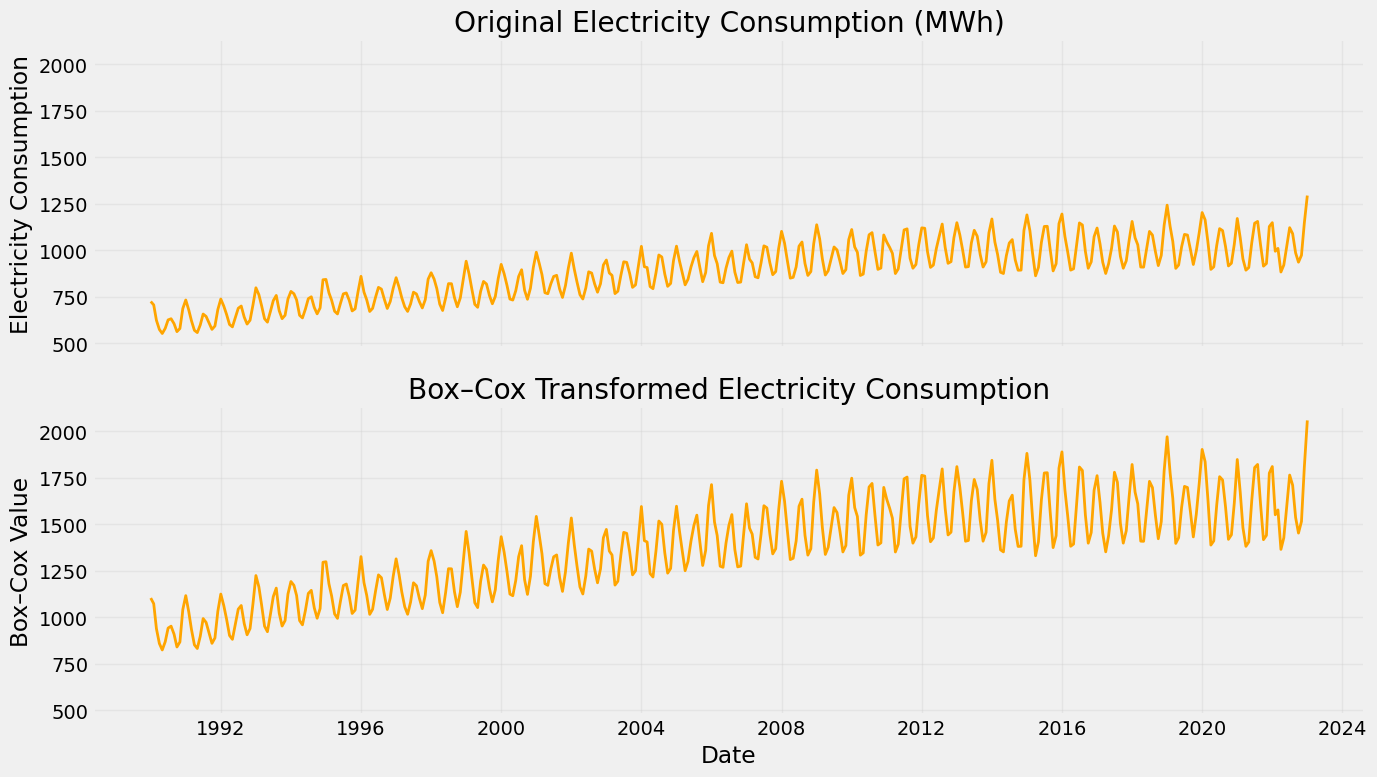

In [240]:
# plot comparison for Electricity
fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True, sharey=True)

# Original Electricity consumption
ax[0].plot(df.index, df["electricity_mwh"], linewidth=2, color=cons_pal["electricity_mwh"])
ax[0].set_title("Original Electricity Consumption (MWh)")
ax[0].set_ylabel("Electricity Consumption")
ax[0].grid(True, alpha=0.3)

# Box–Cox transformed Electricity consumption
ax[1].plot(df.index, df["electricity_mwh_bc"], linewidth=2, color=cons_pal["electricity_mwh"])
ax[1].set_title("Box–Cox Transformed Electricity Consumption")
ax[1].set_ylabel("Box–Cox Value")
ax[1].set_xlabel("Date")
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

- The Box–Cox transformation compresses high gas consumption values, reduces right skewness and stabilises variance, giving a smoother and more model-ready time series.

### First-Order Differencing: `electricity_mwh`

In [241]:
# helper function for plotting
def plot_series(series, title, rolling_window=None, diff=False, color='blue'):
  plt.plot(series, color=color, label='1st Difference' if diff else 'Original', linewidth=2)
  if rolling_window:
    plt.plot(series.rolling(rolling_window).mean(), 'r--', label='Rolling Mean')
    plt.plot(series.rolling(rolling_window).std(), 'k--', label='Rolling Std')
  plt.title(title)
  plt.xlabel('Date')
  plt.ylabel('Electricity Consumption' + (' (Diff)' if diff else ' (MWh)'))
  plt.legend()

ADF Test for Electricity Consumption (Box-Cox Differenced)
Test Statistic: -7.1224
p-value: 0.0000
Critical Values:
   1%: -3.4476
   5%: -2.8692
   10%: -2.5708
Conclusion: Reject H0 → Series is stationary




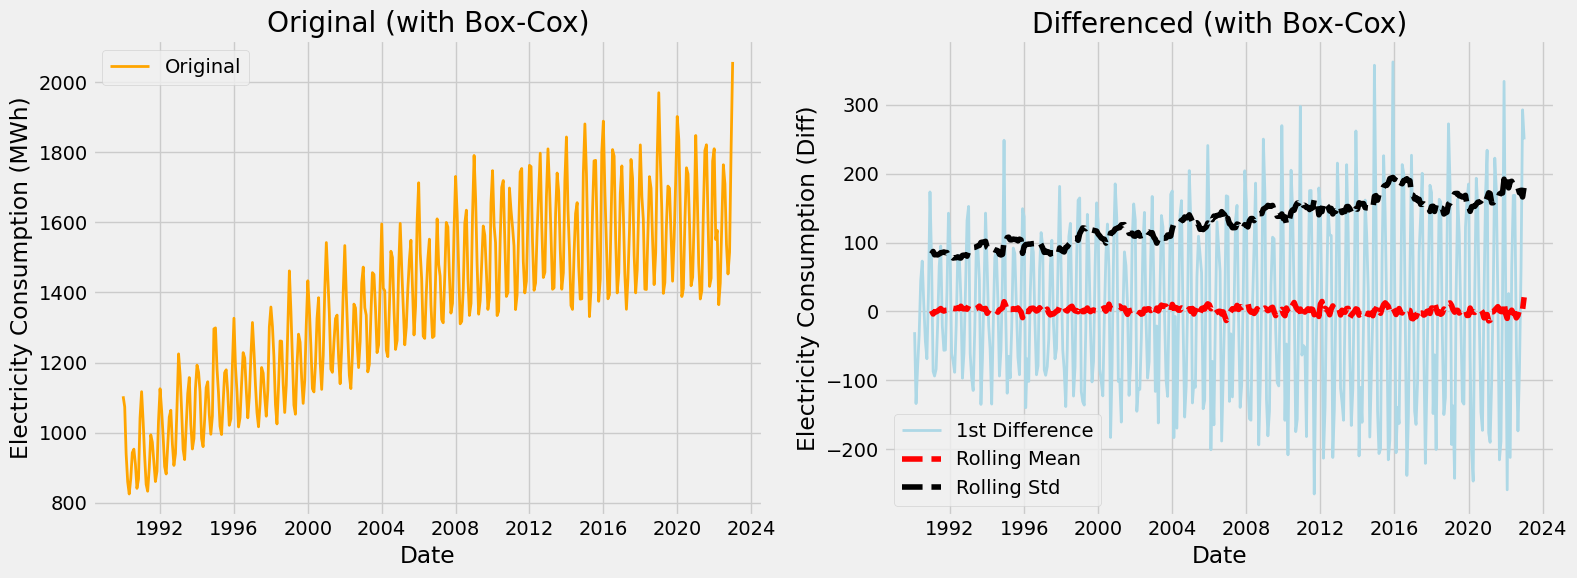

In [242]:
df['electricity_diff1_bc'] = df['electricity_mwh_bc'].diff()
adf_test(df['electricity_diff1_bc'], "Electricity Consumption (Box-Cox Differenced)")

# plot
plt.figure(figsize=(16,6))

# original
plt.subplot(1,2,1)
plot_series(df['electricity_mwh_bc'], 'Original (with Box-Cox)', color=cons_pal["electricity_mwh"])

# differenced (with Box Cox)
plt.subplot(1,2,2)
plot_series(df['electricity_diff1_bc'], 'Differenced (with Box-Cox)', rolling_window=rolling_window, diff=True, color='lightblue')
plt.tight_layout()
plt.show()

ADF Test for Electricity Consumption No Box-Cox
Test Statistic: -7.1048
p-value: 0.0000
Critical Values:
   1%: -3.4476
   5%: -2.8692
   10%: -2.5708
Conclusion: Reject H0 → Series is stationary




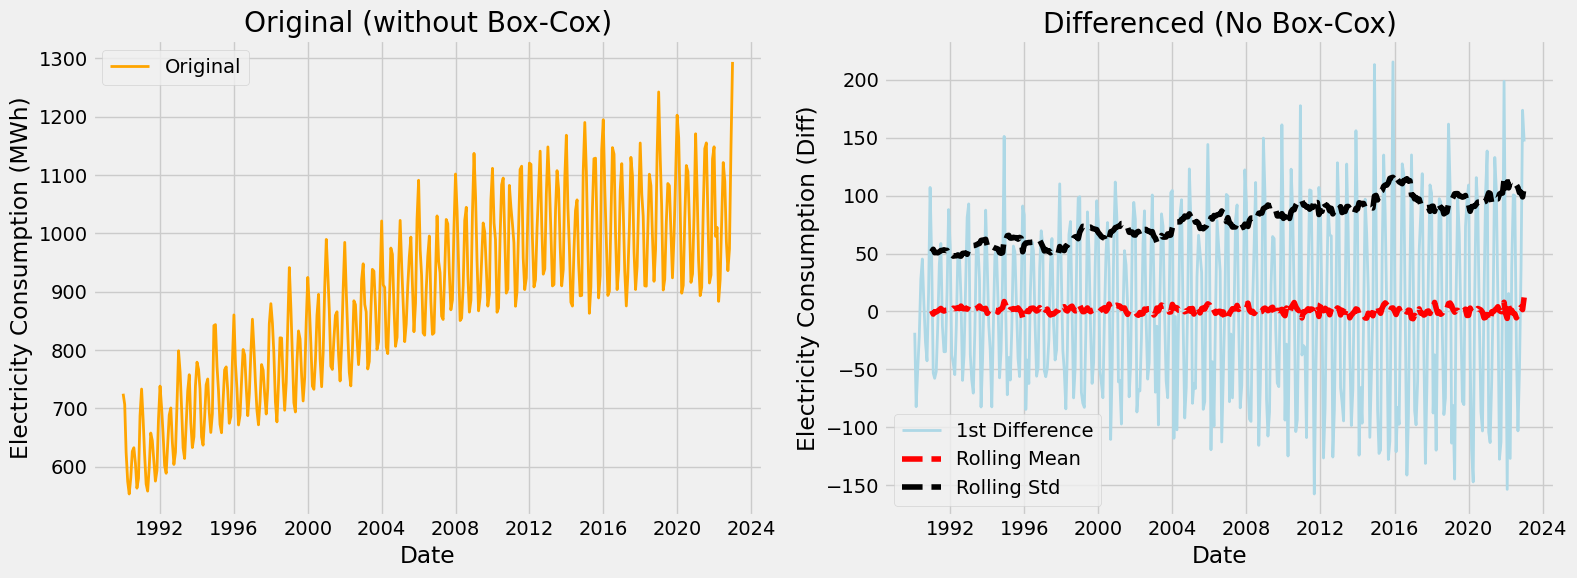

In [243]:
df["electricity_diff1_noBc"] = df["electricity_mwh"].diff()
adf_test(df['electricity_diff1_noBc'], "Electricity Consumption No Box-Cox")

# plot
plt.figure(figsize=(16,6))

# original
plt.subplot(1,2,1)
plot_series(df["electricity_mwh"], title="Original (without Box-Cox)", color=cons_pal["electricity_mwh"])

# differenced (without Box Cox)
plt.subplot(1,2,2)
plot_series(df["electricity_diff1_noBc"], title="Differenced (No Box-Cox)", rolling_window=rolling_window, diff=True, color='lightblue')
plt.tight_layout()
plt.show()

- Electricity Consumption is stationary after differencing once, as seen from the constant mean. 

- Box-Cox transformation does not seem to help, both differenced plots look nearly identical but with different scales.

- Heteroscedasticity observed: variance not constant.The "sin wave" shape in the rolling std is showing:
  - Increasing trend (variance growing over time)
  - Seasonal volatility patterns (regular fluctuations)

### Try Log-Transform
Fix Heteroscedasticity

ADF Test for Log-Transformed electricity
Test Statistic: -6.7482
p-value: 0.0000
Critical Values:
   1%: -3.4476
   5%: -2.8692
   10%: -2.5708
Conclusion: Reject H0 → Series is stationary




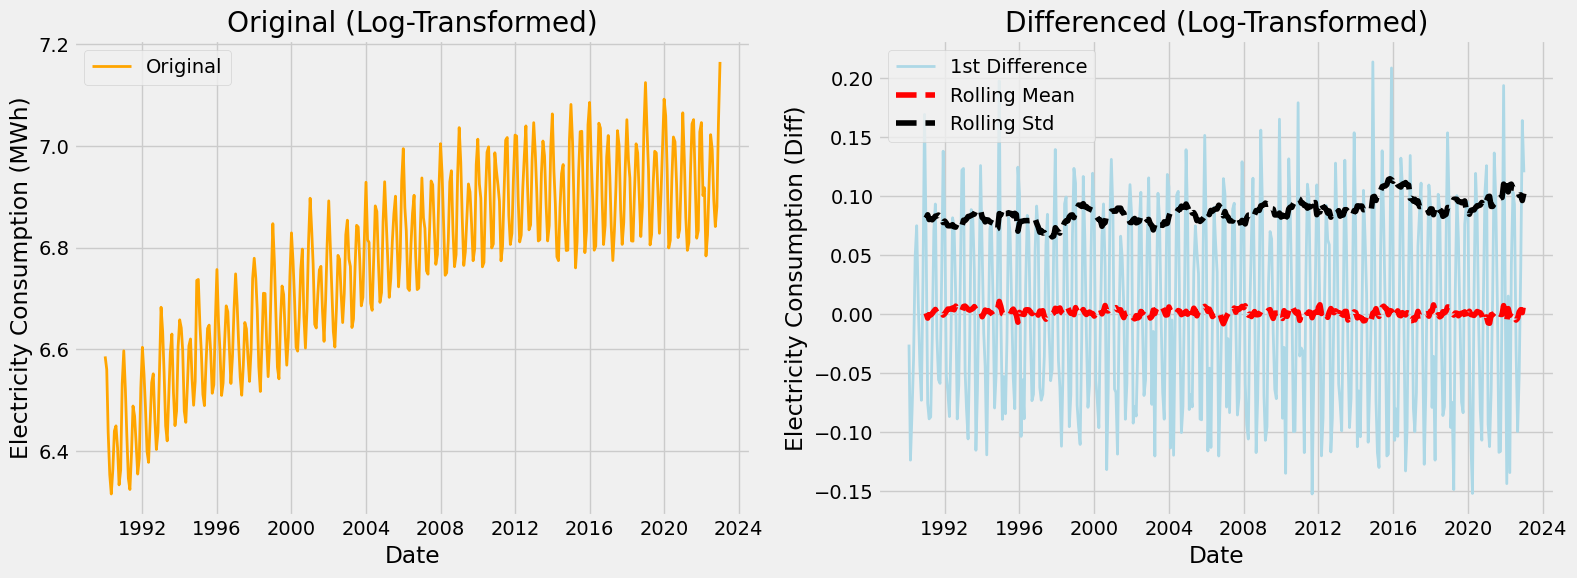

In [244]:
df["electricity_mwh_log"] = np.log(df["electricity_mwh"])
df["electricity_log_diff1"] = df["electricity_mwh_log"].diff().dropna()
adf_test(df["electricity_log_diff1"], "Log-Transformed electricity")

# plot
plt.figure(figsize=(16, 6))

# log transformed
plt.subplot(1,2,1)
plot_series(df['electricity_mwh_log'], 'Original (Log-Transformed)', color=cons_pal["electricity_mwh"])

# differenced (with log transform)
plt.subplot(1,2,2)
plot_series(df["electricity_log_diff1"], title="Differenced (Log-Transformed)", rolling_window=rolling_window, diff=True, color='lightblue')
plt.tight_layout()
plt.show()

- Rolling std more stable (~0.08-0.10 range)
- Rolling mean centered around 0 (good for differenced data)
- Looks acceptable for ARIMA, showed better results for variance than Box-Cox and Scaling

##### **Conclusion: go with Log-Transformed electricity consumption data**

In [245]:
# clean up other test columns
print("BEFORE clean-up:\n", df.columns)
df.drop(columns=["electricity_mwh_bc", "electricity_diff1_bc", "electricity_diff1_noBc"], inplace=True)
print("AFTER clean-up:\n", df.columns)

BEFORE clean-up:
 Index(['gas_tons', 'electricity_mwh', 'water_tons', 'gas_tons_bc',
       'electricity_mwh_bc', 'electricity_diff1_bc', 'electricity_diff1_noBc',
       'electricity_mwh_log', 'electricity_log_diff1'],
      dtype='object')
AFTER clean-up:
 Index(['gas_tons', 'electricity_mwh', 'water_tons', 'gas_tons_bc',
       'electricity_mwh_log', 'electricity_log_diff1'],
      dtype='object')


### Autocorrelation Analysis
Use differenced data to check data is independent.

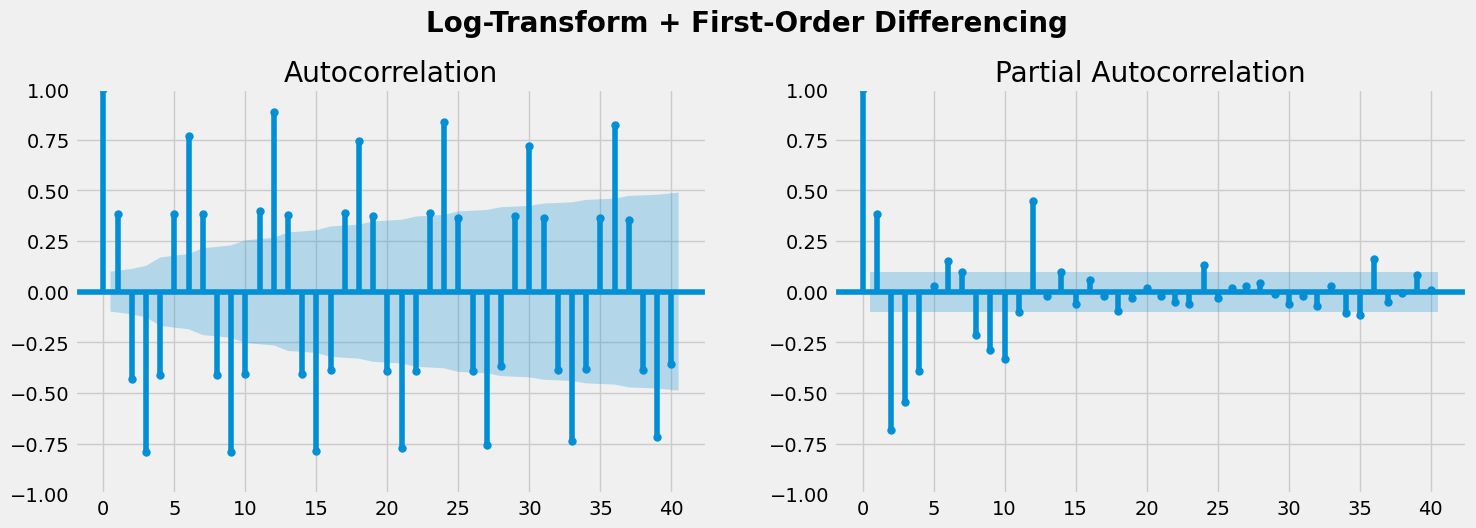

In [246]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(df['electricity_log_diff1'].dropna(), lags=40, ax=ax[0])
plot_pacf(df['electricity_log_diff1'].dropna(), lags=40, ax=ax[1])
plt.suptitle("Log-Transform + First-Order Differencing", fontsize=20, fontweight="bold", y=1.04)
plt.show()

##### **ACF**

🔹 Spikes @ Lag 1–2
  - Significant spikes → short-term dependence
  - Suggests MA or AR terms

🔹 BIG Spikes @ Lag 12, 24, 36
  - Strong 12-month/annual seasonality
  - Confirms seasonal period = 12
  - SARIMA will work better than ARIMA
 
🔹 Slow decay instead of sharp cut-off
  - Spikes are not of equal height, exhibits decreasing trend. Expected for our energy consumption data.

##### **PACF**

🔹 Lag 1–2
  - Significant → AR(1) or AR(2) likely

🔹 Seasonal Spike @ Lag 12
  - Suggests seasonal AR(1)

🔹 After Lag ~15
  - Mostly noise, this is good as model order won’t be huge

##### **Conclusion**
  - Non-seasonal MA component exists
  - Strong seasonal component exists  
  - Seasonal differencing or seasonal AR/MA needed
  - Small p, Seasonal P = 1

### Seasonal Differencing
Our final preprocessing step after inspecting the ACF and PACF plots. They showed a strong seasonality of 12months, which is expected in our energy consumption data.

In [247]:
df["electricity_log_diff1_seasonal"] = df["electricity_log_diff1"].diff(12).dropna()
df.head(1)

,gas_tons,electricity_mwh,water_tons,gas_tons_bc,electricity_mwh_log,electricity_log_diff1,electricity_log_diff1_seasonal
DATE,,,,,,,
1990-01-01,18.0,725.1,548.8,10.939313,6.58631,NaN,NaN


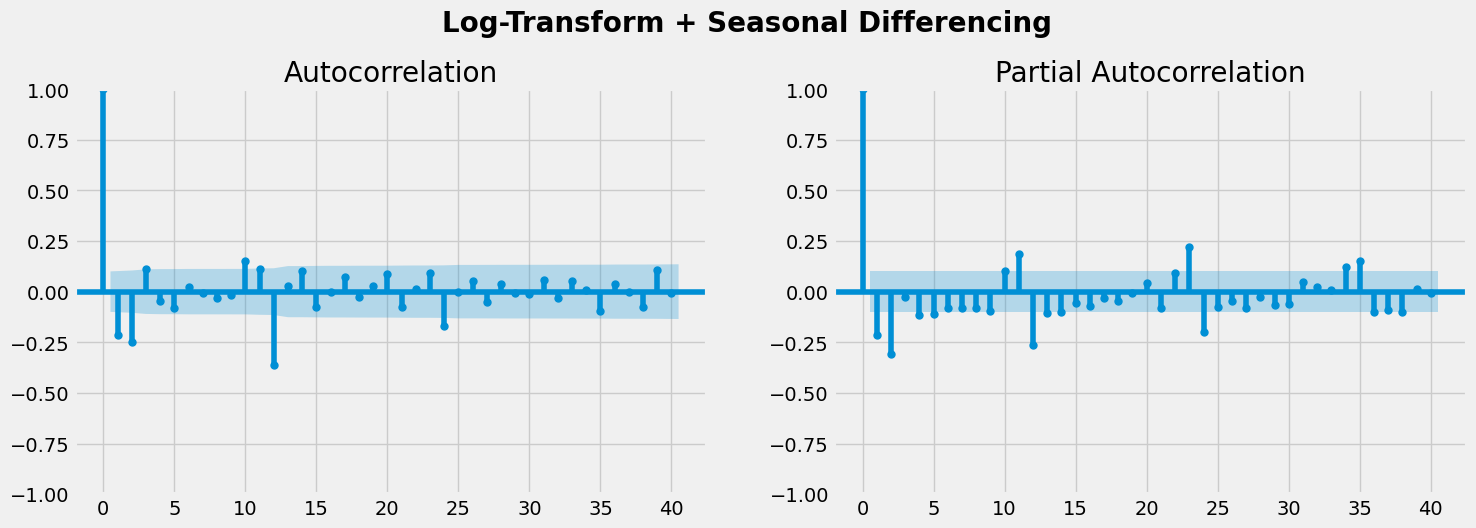

In [248]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(df['electricity_log_diff1_seasonal'].dropna(), lags=40, ax=ax[0])
plot_pacf(df['electricity_log_diff1_seasonal'].dropna(), lags=40, ax=ax[1])
plt.suptitle("Log-Transform + Seasonal Differencing", fontsize=20, fontweight="bold", y=1.04)
plt.show()

- Seasonal Differencing successfully removed most of the seasonality in our electricity consumption data.

---

### **Auto-ARIMA**
Why Auto-ARIMA? It provides a quick and easy way to sanity-check my interpretations and findings above. **Auto ARIMA will NOT be used for my final model fitting**.  
Find the ARIMA with the lowest AIC (Akaike Information Criterion): “How good is the fit while penalising complexity?”  
AIC was only compared within the same dataset to ensure results are valid.

In [249]:
# model = auto_arima(
#   df['electricity_mwh_log'].dropna(), 
#   seasonal=True, m=12, # monthly seasonality
#   trace=True
# )

To prevent long runtimes, I have screenshotted the results below:  
![Auto-ARIMA output](auto-ARIMA-results.png)
Auto-ARIMA found:
```
Best model:  ARIMA(2,1,5)(1,0,2)[12]          
Total fit time: 131.152 seconds
```

➙ p = 2  
➙ d = 1 (ignore, as I already have a differenced electricity column in my df)  
➙ q = 5  
➙ Seasonal AR(1), MA(2), ___no seasonal differencing___, season length of 12  

Most of Auto-ARIMA's results align with ours, except the lack of seasonal differencing is strange. We will try comparing ARIMA and SARIMA in the subsequent Modelling section.

---

## **STAGE 3: Modelling & Evaluation**

### Compare ARIMA & SARIMA

#### Electricity Consumption (kWh)

##### ARIMA

                                SARIMAX Results                                
Dep. Variable:     electricity_mwh_log   No. Observations:                  397
Model:                  ARIMA(2, 1, 5)   Log Likelihood                 750.645
Date:                 Sat, 31 Jan 2026   AIC                          -1485.291
Time:                         16:24:36   BIC                          -1453.440
Sample:                     01-01-1990   HQIC                         -1472.672
                          - 01-01-2023                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9922      0.007    151.173      0.000       0.979       1.005
ar.L2         -0.9901      0.006   -174.005      0.000      -1.001      -0.979
ma.L1         -1.1818      0.048    -24.412 

C:\Users\lokej\AppData\Roaming\Python\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,lb_stat,lb_pvalue
12,0.440981,1.0
24,0.599959,1.0


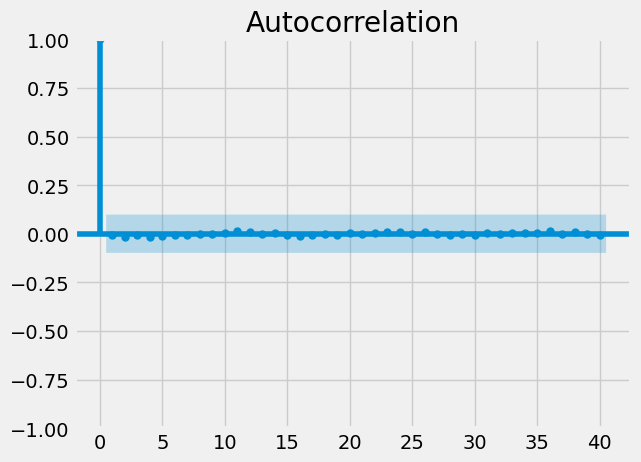

In [250]:
# train ARIMA with 1st-Differencing and No Seasonal Differencing
model = ARIMA(
  df["electricity_mwh_log"],
  order=(2, 1, 5) # p, d, q
)

results = model.fit()

print(results.summary())
plot_acf(results.resid.dropna(), lags=40) # plot residual ACF
acorr_ljungbox(results.resid.dropna(), lags=[12, 24], return_df=True) # Ljung-Box test

##### SARIMA

C:\Users\lokej\AppData\Roaming\Python\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                        SARIMAX Results                                        
Dep. Variable:                     electricity_mwh_log   No. Observations:                  397
Model:             SARIMAX(2, 1, 5)x(1, 1, [1, 2], 12)   Log Likelihood                 805.841
Date:                                 Sat, 31 Jan 2026   AIC                          -1589.682
Time:                                         16:24:43   BIC                          -1547.120
Sample:                                     01-01-1990   HQIC                         -1572.748
                                          - 01-01-2023                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4646      0.518      0.898      0.369      -0.550       1

,lb_stat,lb_pvalue
12,73.405208,7.347717e-11
24,92.248982,6.098201e-10


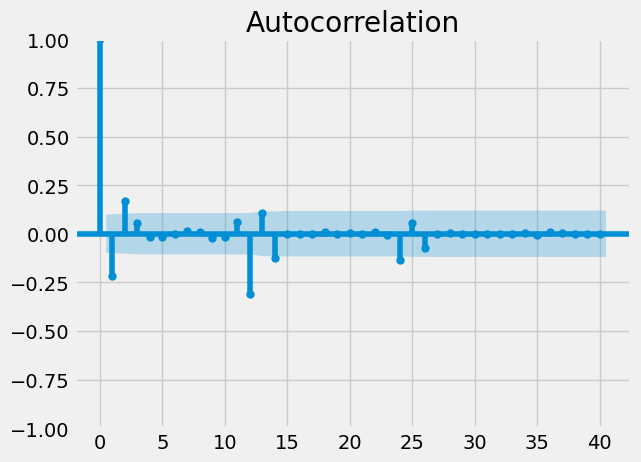

In [251]:
model = SARIMAX(
  df["electricity_mwh_log"],
  order=(2, 1, 5), # p, d, q
  seasonal_order=(1, 1, 2, 12), # P, D, Q, m
  enforce_stationarity=False,
  enforce_invertibility=False
)

results = model.fit()

print(results.summary())
plot_acf(results.resid.dropna(), lags=40) # plot residual ACF
acorr_ljungbox(results.resid.dropna(), lags=[12, 24], return_df=True) # Ljung-Box test

#### Gas Consumption (tons)

In [252]:
model = SARIMAX(
  df["electricity_log_diff1"],
  order=(2, 0, 5), # p, d, q
  seasonal_order=(1, 0, 2, 12), # P, D, Q, m
  enforce_stationarity=False,
  enforce_invertibility=False
)

results = model.fit()
print(results.summary())

                                        SARIMAX Results                                        
Dep. Variable:                   electricity_log_diff1   No. Observations:                  397
Model:             SARIMAX(2, 0, 5)x(1, 0, [1, 2], 12)   Log Likelihood                 835.348
Date:                                 Sat, 31 Jan 2026   AIC                          -1648.697
Time:                                         16:24:45   BIC                          -1605.738
Sample:                                     01-01-1990   HQIC                         -1631.628
                                          - 01-01-2023                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0383      0.419      2.478      0.013       0.217       1

C:\Users\lokej\AppData\Roaming\Python\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### Water Consumption (tons)

### Hyperparameter Tuning 
ARIMA(p, d, q) - explain how i found best p d q  
GridSearchCV?  
RMSE/MAE?  
Select best model per utility (best for grid and rmse/mae respectively. explore other methods)

### Model Diagnostics
Residual plots
Residual ACF
Ljung–Box test (optional)

Check: Residuals ≈ white noise

#### Residual ACF

#### Ljung-Box Test

#### Visual Evaluation
Plot:
- Actual vs predicted (train, validation, test)
- Forecast with confidence intervals

---

## **STAGE 4: Model Improvement**
Compare ARIMA vs:
1. Naive forecast
2. Simple moving average

3. Upgrade to SARIMA, explain Seasonal (P, D, Q, s)  
  a. Seasonal ARIMA (if seasonality exists)


Model refinement
- Adjust differencing
- Remove unnecessary AR or MA terms

Trade-off between:
1. Complexity
2. Interpretability
3. Overfitting

Final model justification  
Why chosen model performs best  
Why others underperform

### 